In [29]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [30]:
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)
@njit
def rolling_mean_30(x):
    return rolling_mean(x, window_size=30)

In [31]:
def format_df_to_mlforecast(df, date_col, target_col, unique_id='mean'):
    df_ = df.rename({
        date_col: "ds",
        # target_col: 'y',
    }, axis=1)

    df_['ds'] = pd.to_datetime(df_['ds'])

    df_['y'] = df_[target_col].copy()
    # df_.drop(columns=target_col)

    df_['unique_id'] = unique_id
    return df_

In [32]:
selected_sensors_df = pd.read_csv("../data/selected_sensors2_cleaned.csv", index_col=0)

<Axes: >

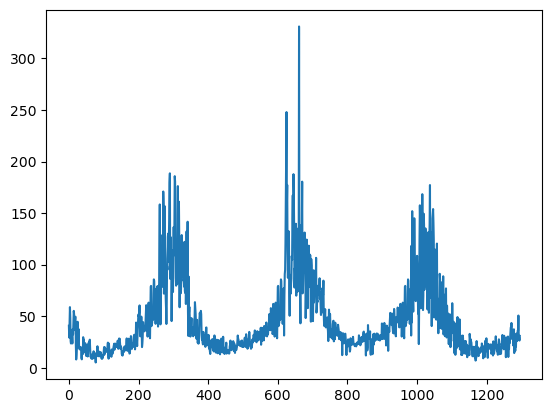

In [33]:
selected_sensors_df['2'].plot()

In [ ]:
scenarios_sensors = {
    # 0: 1, 4372603
    # "0_12M_train_7M_test": {"train_start": "2017-03-25", "train_end": "2018-03-25", "test_start": "2018-03-26", "test_end": "2018-10-10"},
    '2': {
        "26M_train":  {"train_start": "2017-04-01", "train_end": "2019-06-01"},
        "24M_train":  {"train_start": "2017-04-01", "train_end": "2019-04-01"},
        "22M_train":  {"train_start": "2017-04-01", "train_end": "2019-02-01"},
        "20M_train":  {"train_start": "2017-04-01", "train_end": "2018-12-01"},
        "18M_train":  {"train_start": "2017-04-01", "train_end": "2018-10-01"},
        "12M_train":  {"train_start": "2017-04-01", "train_end": "2018-04-01"},
        "10M_train":  {"train_start": "2017-04-01", "train_end": "2018-01-25"},
        "8M_train":   {"train_start": "2017-04-01", "train_end": "2017-10-25"},
        
        # Non-Heating Periods
        "NH_3M_train":  {"train_start": "2017-04-15", "train_end": "2017-07-15"},
        "NH_4M_train":  {"train_start": "2017-04-15", "train_end": "2017-08-15"},
        "NH_2M_train":  {"train_start": "2017-04-15", "train_end": "2017-06-15"},
        "NH_1M_train":  {"train_start": "2017-04-15", "train_end": "2017-05-15"},
        "NH_15D_train": {"train_start": "2017-04-15", "train_end": "2017-04-30"},
        "NH_feb_2M_train": {"train_start": "2017-02-15", "train_end": "2017-04-15"},
        "NH_feb_1M_train": {"train_start": "2017-02-15", "train_end": "2017-04-15"},
        "NH_mar_2M_train": {"train_start": "2017-03-15", "train_end": "2017-05-15"},
        "NH_mar_1M_train": {"train_start": "2017-03-15", "train_end": "2017-04-15"},

        # Heating Periods
        "H_5M_train":     {"train_start": "2017-06-01", "train_end": "2017-11-01"},
        "H_3M_jul_train": {"train_start": "2017-07-01", "train_end": "2017-10-10"},
        "H_3M_sep_train": {"train_start": "2017-09-01", "train_end": "2017-12-10"},
        "H_3M_nov_train": {"train_start": "2017-11-01", "train_end": "2018-02-10"},
        },
}
scenarios_sensors['5'] = scenarios_sensors['2'].copy()
scenarios_sensors['6'] = scenarios_sensors['2'].copy()

In [35]:
from MLForecastPipeline import *

In [36]:
def split_data(df, scenario, date_col="ds"):
    """Extracts train and test data based on train end date."""
    train_data = df[df[date_col] <= scenario['train_end']]
    test_start = pd.to_datetime(scenario['train_end']) + pd.Timedelta(days=1)
    test_data = df[df[date_col] >= test_start]
    return train_data, test_data

models = {
    "XGBRegressor": XGBRegressor(),
    "SGDRegressor_42": SGDRegressor(random_state=42),
    # "SGDRegressor_1": SGDRegressor(random_state=1),
    "Ridge": Ridge(),
    "Lasso": Lasso()
}

# Define lag transformations

lag_transforms_options = [
    {1: [expanding_mean], 7: [rolling_mean_14], 30: [expanding_mean]},
    {1: [rolling_mean_14], 7: [rolling_mean_30], 30: [expanding_mean]},
    # {1: [rolling_mean_14], 30: [expanding_mean]},
    # {1: [rolling_mean_14]},
    # {},
]

In [37]:
# from tqdm.notebook import trange, tqdm
# from time import sleep

# for i in trange(3, desc='1st loop'):
#     for j in tqdm(range(100), desc='2nd loop'):
#         sleep(0.01)

In [38]:
from joblib import Parallel, delayed
import time

def process_scenario(sensor_name, scenario_name, scenario, selected_sensors_df, models, lag_transforms_options, ratios=[0.33, 0.66, 1]):
    """ Process each scenario independently and save results. """
    print(f'{sensor_name}_{scenario_name}')
    formatted_df = format_df_to_mlforecast(selected_sensors_df[['full_date', sensor_name]], 'full_date', sensor_name, unique_id=sensor_name)
    formatted_df = formatted_df[['ds', 'y', 'unique_id']]
    
    train_df, test_df = split_data(formatted_df, scenario)
    optimal_lags_list = get_optimal_lags(train_df, 'y', ratios=ratios)
    target_transforms = get_dynamic_transforms(train_df)

    results = evaluate_models(train_df, test_df, models, target_transforms, lag_transforms_options, optimal_lags_list)

    # Save results
    save_results(results, f"results/run_3/{sensor_name}_{scenario_name}.csv")

    return results

def run_all_scenarios_parallel(scenarios_sensors, selected_sensors_df, models, lag_transforms_options, ratios=[0.33, 0.66, 1]):
    # don't use all cpus (instead all but one)
    results = Parallel(n_jobs=15)( 
        delayed(process_scenario)(sensor_name, scenario_name, scenario, selected_sensors_df, models, lag_transforms_options, ratios=ratios)
        for sensor_name, scenarios in scenarios_sensors.items()
        for scenario_name, scenario in scenarios.items()
    )

    return results


In [39]:
# models = {
#     "Lasso": Lasso()
# }

# # Define lag transformations

# lag_transforms_options = [
#     {1: [expanding_mean], 7: [rolling_mean_14], 30: [expanding_mean]},
# ]
# results = run_all_scenarios_parallel(scenarios_sensors, selected_sensors_df, models, lag_transforms_options, ratios=[1])

In [ ]:
results = run_all_scenarios_parallel(scenarios_sensors, selected_sensors_df, models, lag_transforms_options)

In [28]:
import multiprocessing
cpu_count = multiprocessing.cpu_count()
cpu_count

16

In [23]:
# Loop through scenarios and evaluate models
results = []

for sensor_name, scenarios in scenarios_sensors.items():
    formatted_df = format_df_to_mlforecast(selected_sensors_df[['full_date', sensor_name]], 'full_date', sensor_name, unique_id=sensor_name)
    formatted_df = formatted_df[['ds', 'y', 'unique_id']]

    for scenario_name, scenario in scenarios.items():

        train_df, test_df = split_data(formatted_df, scenario)

        optimal_lags_list = get_optimal_lags(train_df, 'y', 
                                            # ratios=[1]
                                            ratios=[0.33, 0.66, 1]
                                            #  ratios=[0.25, 0.5, 0.75, 1]
        )
        target_transforms = get_dynamic_transforms(train_df)
        results = evaluate_models(train_df, test_df, models, target_transforms, lag_transforms_options, optimal_lags_list)

        save_results(results, f"results/run_3/{sensor_name}_{scenario_name}.csv") 

Total model fits to run: 1152
0/1152 Training XGBRegressor with transforms (), lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 27, 36, 37, 41, 43, 48, 54, 63, 64, 73, 74, 77, 78, 79, 80, 81, 97, 98], and lag_transforms {1: [<function expanding_mean at 0x00000255F6108720>], 7: [<function rolling_mean_14 at 0x00000255838B0AE0>], 30: [<function expanding_mean at 0x00000255F6108720>]}...
XGBRegressor MAPE: 41.45% with transforms (), lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 27, 36, 37, 41, 43, 48, 54, 63, 64, 73, 74, 77, 78, 79, 80, 81, 97, 98], and lag_transforms {1: [<function expanding_mean at 0x00000255F6108720>], 7: [<function rolling_mean_14 at 0x00000255838B0AE0>], 30: [<function expanding_mean at 0x00000255F6108720>]}
1/1152 Training SGDRegressor_42 with transforms (), lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 27, 36, 37, 41, 43, 48, 54, 63, 64, 73, 74, 77, 78, 79, 80, 81, 97, 98], and lag_transforms {1: [<function expanding_mean at 0x00000255

c:\Users\PC314\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\PC314\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\PC314\anaconda3\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag1, expanding_mean_lag1.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


Ridge MAPE: 63.23% with transforms (), lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 27, 36, 37, 41, 43, 48, 54, 63, 64, 73, 74, 77, 78, 79, 80, 81, 97, 98], and lag_transforms {1: [<function expanding_mean at 0x00000255F6108720>], 7: [<function rolling_mean_14 at 0x00000255838B0AE0>], 30: [<function expanding_mean at 0x00000255F6108720>]}
3/1152 Training Lasso with transforms (), lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 27, 36, 37, 41, 43, 48, 54, 63, 64, 73, 74, 77, 78, 79, 80, 81, 97, 98], and lag_transforms {1: [<function expanding_mean at 0x00000255F6108720>], 7: [<function rolling_mean_14 at 0x00000255838B0AE0>], 30: [<function expanding_mean at 0x00000255F6108720>]}...
Lasso MAPE: 42.30% with transforms (), lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 27, 36, 37, 41, 43, 48, 54, 63, 64, 73, 74, 77, 78, 79, 80, 81, 97, 98], and lag_transforms {1: [<function expanding_mean at 0x00000255F6108720>], 7: [<function rolling_mean_14 at 0x0000025583

c:\Users\PC314\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\PC314\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\PC314\anaconda3\Lib\site-packages\mlforecast\core.py:625: UserWarning: Found null values in lag1, rolling_mean_14_lag1.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')


Ridge MAPE: 49.97% with transforms (), lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 27, 36, 37, 41, 43, 48, 54, 63, 64, 73, 74, 77, 78, 79, 80, 81, 97, 98], and lag_transforms {1: [<function rolling_mean_14 at 0x00000255838B0AE0>], 7: [<function rolling_mean_30 at 0x00000255838B0FE0>], 30: [<function expanding_mean at 0x00000255F6108720>]}
7/1152 Training Lasso with transforms (), lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 27, 36, 37, 41, 43, 48, 54, 63, 64, 73, 74, 77, 78, 79, 80, 81, 97, 98], and lag_transforms {1: [<function rolling_mean_14 at 0x00000255838B0AE0>], 7: [<function rolling_mean_30 at 0x00000255838B0FE0>], 30: [<function expanding_mean at 0x00000255F6108720>]}...
Lasso MAPE: 42.06% with transforms (), lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 27, 36, 37, 41, 43, 48, 54, 63, 64, 73, 74, 77, 78, 79, 80, 81, 97, 98], and lag_transforms {1: [<function rolling_mean_14 at 0x00000255838B0AE0>], 7: [<function rolling_mean_30 at 0x0000025

c:\Users\PC314\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


Ridge MAPE: 68.08% with transforms (<mlforecast.target_transforms.AutoDifferences object at 0x00000255F9608830>,), lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 27, 36, 37, 41, 43, 48, 54, 63, 64, 73, 74, 77, 78, 79, 80, 81, 97, 98], and lag_transforms {1: [<function expanding_mean at 0x00000255F6108720>], 7: [<function rolling_mean_14 at 0x00000255838B0AE0>], 30: [<function expanding_mean at 0x00000255F6108720>]}
11/1152 Training Lasso with transforms (<mlforecast.target_transforms.AutoDifferences object at 0x00000255F9608830>,), lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 27, 36, 37, 41, 43, 48, 54, 63, 64, 73, 74, 77, 78, 79, 80, 81, 97, 98], and lag_transforms {1: [<function expanding_mean at 0x00000255F6108720>], 7: [<function rolling_mean_14 at 0x00000255838B0AE0>], 30: [<function expanding_mean at 0x00000255F6108720>]}...
Lasso MAPE: 49.63% with transforms (<mlforecast.target_transforms.AutoDifferences object at 0x00000255F9608830>,), lags [1, 2, 3, 4, 5,

KeyboardInterrupt: 